<h1><b>Ministry Classification Model</b></h1>

<h3>We will be only considering the first 550 character of the (title + content) for our prediction, Due to the computational limitation</h3>

<h2>TODO</h2>
<ul>
<li>Make the dataset to be divided into the train, validation and the test part</li>  
<li>Padding length is to be set, According to the result wanted, Currently padding length is seted to the `550`.</li>    
<li>It is remaining to make the test dataset, And by help of the padding make sure in it that the input size is same as that of the input layer, otherwise it will give an error</li>
</ul>

<h1>Process 1: Importing the Libraries</h1>

In [1]:
# For basic dataframe and mathematical operations
import numpy as np
import pandas as pd

# For Deep Learning Model
import tensorflow as tf
from tensorflow import keras
import os

# For natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# For utility
import re
# import lgging
import time
import pickle
import itertools


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h2>Processs 2: Code for configuring multiple GPUs</h2>

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 339584894442420265
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 12025117768910294859
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14337966080
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 943200463127196879
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


<h1>Process 3: Making press release dataset ready for giving it as input to classification model</h1>

In [3]:
df1 = pd.read_csv("/kaggle/input/press-release/press_release_2003.csv", encoding='unicode_escape')
df2 = pd.read_csv("/kaggle/input/press-release/press_release_2004.csv", encoding='unicode_escape')
df3 = pd.read_csv("/kaggle/input/press-release/press_release_2005.csv", encoding='unicode_escape')

<h2>Managining new 61th i.e. no ministry labeled datatset for classification model</h2>

In [4]:
df4 = pd.read_csv("/kaggle/input/sentiment-labeled-headlines/Sentiments/cnbc_sentiment.csv", encoding='unicode_escape')
df5 = pd.read_csv("/kaggle/input/sentiment-labeled-headlines/Sentiments/guardian_sentiment.csv", encoding='unicode_escape')
df6 = pd.read_csv("/kaggle/input/sentiment-labeled-headlines/Sentiments/reuters_sentiment.csv", encoding='unicode_escape')

In [5]:
for i in range(len(df4)):
    df4.loc[i, 'Sentiment'] = str(61)
    
for i in range(len(df5)):
    df5.loc[i, 'Sentiment'] = str(61)
    
for i in range(len(df6)):
    df6.loc[i, 'Sentiment'] = str(61)

In [6]:
df4.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
df4.rename(columns={'Headlines':'content', 'Sentiment':'label'}, inplace=True)

df5.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
df5.rename(columns={'Headlines':'content', 'Sentiment':'label'}, inplace=True)

df6.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
df6.rename(columns={'Headlines':'content', 'Sentiment':'label'}, inplace=True)

<h2>Managing press release dataset</h2>

In [7]:
df = pd.concat([df1, df2, df3], ignore_index=True)

In [8]:
ministry_list = df['pr_issued_by'].unique()
print(ministry_list)

['Ministry of Railways' 'Ministry of Rural Development'
 'Ministry of Steel' 'Ministry of Science & Technology'
 'Ministry of Information & Broadcasting'
 'Ministry of Food Processing Industries'
 'Ministry of Health and Family Welfare'
 'Ministry of Human Resource Development' 'Ministry of Agriculture'
 'Ministry of Environment and Forests'
 'Ministry of Chemicals and Fertilizers' 'Ministry of Water Resources'
 'Ministry of Defence' 'Ministry of Petroleum & Natural Gas'
 "President's Secretariat" 'Ministry of Micro,Small & Medium Enterprises'
 'Ministry of Mines' 'Ministry of Tourism'
 'Ministry of Housing & Urban Affairs' 'Ministry of Coal'
 "Prime Minister's Office" 'Ministry of Textiles'
 'Ministry of Commerce & Industry' 'Ministry of External Affairs'
 'Ministry of Social Justice & Empowerment' 'Ministry of Power'
 'Ministry of Consumer Affairs, Food & Public Distribution'
 'Ministry of Heavy Industries & Public Enterprises'
 'Ministry of Communications' 'Ministry of Shipping' 'Mi

<h2>List of the ministry and it's specific index number</h2>
<ul>
<li> 0 Ministry of Railways </li>
<li> 1 Ministry of Rural Development </li>
<li> 2 Ministry of Steel </li>
<li> 3 Ministry of Science & Technology </li>
<li> 4 Ministry of Information & Broadcasting </li>
<li> 5 Ministry of Food Processing Industries </li>
<li> 6 Ministry of Health and Family Welfare </li>
<li> 7 Ministry of Human Resource Development </li>
<li> 8 Ministry of Agriculture </li>
<li> 9 Ministry of Environment and Forests </li>
<li> 10 Ministry of Chemicals and Fertilizers </li>
<li> 11 Ministry of Water Resources </li>
<li> 12 Ministry of Defence </li>
<li> 13 Ministry of Petroleum & Natural Gas </li>
<li> 14 President's Secretariat </li>
<li> 15 Ministry of Micro,Small & Medium Enterprises </li>
<li> 16 Ministry of Mines </li>
<li> 17 Ministry of Tourism </li>
<li> 18 Ministry of Housing & Urban Affairs </li>
<li> 19 Ministry of Coal </li>
<li> 20 Prime Minister's Office </li>
<li> 21 Ministry of Textiles </li>
<li> 22 Ministry of Commerce & Industry </li>
<li> 23 Ministry of External Affairs </li>
<li> 24 Ministry of Social Justice & Empowerment </li>
<li> 25 Ministry of Power </li>
<li> 26 Ministry of Consumer Affairs, Food & Public Distribution </li>
<li> 27 Ministry of Heavy Industries & Public Enterprises </li>
<li> 28 Ministry of Communications </li>
<li> 29 Ministry of Shipping </li>
<li> 30 Ministry of Finance </li>
<li> 31 Ministry of Tribal Affairs </li>
<li> 32 Ministry of Statistics & Programme Implementation </li>
<li> 33 Ministry of Labour & Employment </li>
<li> 34 Ministry of Law & Justice </li>
<li> 35 Vice President's Secretariat </li>
<li> 36 Ministry of Civil Aviation </li>
<li> 37 Ministry for Development of North-East Region </li>
<li> 38 UPSC </li>
<li> 39 Ministry of Agro & Rural Industries </li>
<li> 40 Ministry of Home Affairs </li>
<li> 41 Ministry of Youth Affairs and Sports </li>
<li> 42 Special Service and Features </li>
<li> 43 Ministry of New and Renewable Energy </li>
<li> 44 Ministry of Parliamentary Affairs </li>
<li> 45 Planning Commission </li>
<li> 46 Ministry of Personnel, Public Grievances & Pensions </li>
<li> 47 Election Commission </li>
<li> 48 Department of Space </li>
<li> 49 Ministry of Disinvestment </li>
<li> 50 Department of Ocean Development </li>
<li> 51 Ministry of Overseas Indian Affairs </li>
<li> 52 Ministry of Housing and Urban Poverty Alleviation </li>
<li> 53 Ministry of Culture </li>
<li> 54 Ministry of Company Affairs </li>
<li> 55 Ministry of Panchayati Raj </li>
<li> 56 Cabinet Committee on Economic Affairs (CCEA) </li>
<li> 57 Cabinet </li>
<li> 58 Department of Atomic Energy </li>
<li> 59 Cabinet Committee Decisions </li>
<li>60 No Ministry</li>
</ul>

<b>Mapping the ministry to the it's index number starting from the 1 and `0` is made reserved for the `Not Ministry`, If any news doesn't belongs to any ministry of our current ministry dataset, So total labels are `59+1(no ministry)`</b>

In [9]:
ministry_dictonary = {}

ministry_dictonary["Not Ministry"] = 61

label = 1
for v in ministry_list:
    ministry_dictonary[v] = label
    label += 1

In [10]:
ministry_dictonary.items()

dict_items([('Not Ministry', 61), ('Ministry of Railways', 1), ('Ministry of Rural Development', 2), ('Ministry of Steel', 3), ('Ministry of Science & Technology', 4), ('Ministry of Information & Broadcasting', 5), ('Ministry of Food Processing Industries', 6), ('Ministry of Health and Family Welfare', 7), ('Ministry of Human Resource Development', 8), ('Ministry of Agriculture', 9), ('Ministry of Environment and Forests', 10), ('Ministry of Chemicals and Fertilizers', 11), ('Ministry of Water Resources', 12), ('Ministry of Defence', 13), ('Ministry of Petroleum & Natural Gas', 14), ("President's Secretariat", 15), ('Ministry of Micro,Small & Medium Enterprises', 16), ('Ministry of Mines', 17), ('Ministry of Tourism', 18), ('Ministry of Housing & Urban Affairs', 19), ('Ministry of Coal', 20), ("Prime Minister's Office", 21), ('Ministry of Textiles', 22), ('Ministry of Commerce & Industry', 23), ('Ministry of External Affairs', 24), ('Ministry of Social Justice & Empowerment', 25), ('Mi

In [11]:
df.head()

,pr_id,pr_datetime,pr_issued_by,pr_title,pr_content
0,29,08-December-2003 11:52 IST,Ministry of Railways,STEAM LOCOMOTIVES FOR PROMOTION OF HERITAGE TO...,Indian Railways have earmarked Nilgiri Mountai...
1,35,08-December-2003 12:24 IST,Ministry of Rural Development,ADDITIONAL CENTRAL ASSISTANCE TO ASSAM TO REST...,Ministry of Rural Development has released fun...
2,39,08-December-2003 12:46 IST,Ministry of Steel,UPGRADATION OF EXISTING FACILITIES BY SAIL,LOK SABHA Steel Authority of India Limited (SA...
3,40,08-December-2003 12:47 IST,Ministry of Steel,EXPANSION OF VISAKHAPATNAM STEEL PLANT,LOK SABHA There is a proposal for installation...
4,41,08-December-2003 13:26 IST,Ministry of Railways,EMPHASIS ON USE OF HINDI IN RAILWAYS,"The Chairman, Railway Board, Shri R.K.Singh ha..."


In [12]:
df.iloc[0, 2][11:]

' Railways'

In [13]:
for i in range(len(df)):
    df.iloc[i, 3] = str(df.iloc[i, 3]) + str(df.iloc[i, 2][11:])
    df.iloc[i, 2] = ministry_dictonary.get(df.iloc[i, 2])

In [14]:
df.head()

,pr_id,pr_datetime,pr_issued_by,pr_title,pr_content
0,29,08-December-2003 11:52 IST,1,STEAM LOCOMOTIVES FOR PROMOTION OF HERITAGE TO...,Indian Railways have earmarked Nilgiri Mountai...
1,35,08-December-2003 12:24 IST,2,ADDITIONAL CENTRAL ASSISTANCE TO ASSAM TO REST...,Ministry of Rural Development has released fun...
2,39,08-December-2003 12:46 IST,3,UPGRADATION OF EXISTING FACILITIES BY SAIL Steel,LOK SABHA Steel Authority of India Limited (SA...
3,40,08-December-2003 12:47 IST,3,EXPANSION OF VISAKHAPATNAM STEEL PLANT Steel,LOK SABHA There is a proposal for installation...
4,41,08-December-2003 13:26 IST,1,EMPHASIS ON USE OF HINDI IN RAILWAYS Railways,"The Chairman, Railway Board, Shri R.K.Singh ha..."


In [15]:
df.rename(columns={'pr_issued_by':'label'}, inplace=True)
df.head()

,pr_id,pr_datetime,label,pr_title,pr_content
0,29,08-December-2003 11:52 IST,1,STEAM LOCOMOTIVES FOR PROMOTION OF HERITAGE TO...,Indian Railways have earmarked Nilgiri Mountai...
1,35,08-December-2003 12:24 IST,2,ADDITIONAL CENTRAL ASSISTANCE TO ASSAM TO REST...,Ministry of Rural Development has released fun...
2,39,08-December-2003 12:46 IST,3,UPGRADATION OF EXISTING FACILITIES BY SAIL Steel,LOK SABHA Steel Authority of India Limited (SA...
3,40,08-December-2003 12:47 IST,3,EXPANSION OF VISAKHAPATNAM STEEL PLANT Steel,LOK SABHA There is a proposal for installation...
4,41,08-December-2003 13:26 IST,1,EMPHASIS ON USE OF HINDI IN RAILWAYS Railways,"The Chairman, Railway Board, Shri R.K.Singh ha..."


<h3>Making the cocatination of the pr_title and pr_content in the new field named content</h3>

In [16]:
for i in range(len(df)):       
    if pd.isnull(df.loc[i, 'pr_title']):
        df.loc[i, 'content'] = str(df.loc[i, 'pr_content'])[:550]
    elif pd.isnull(df.loc[i, 'pr_content']):
        df.loc[i, 'content'] = str(df.loc[i, 'pr_title'])[:550]
    else:
        df.loc[i, 'content'] = (str(df.loc[i, 'pr_title']) + " " + str(df.loc[i, 'pr_content']))[:550]
df.drop(columns=['pr_datetime', 'pr_id', 'pr_title', 'pr_content'], inplace=True)

In [17]:
df.head()

,label,content
0,1,STEAM LOCOMOTIVES FOR PROMOTION OF HERITAGE TO...
1,2,ADDITIONAL CENTRAL ASSISTANCE TO ASSAM TO REST...
2,3,UPGRADATION OF EXISTING FACILITIES BY SAIL Ste...
3,3,EXPANSION OF VISAKHAPATNAM STEEL PLANT Steel L...
4,1,EMPHASIS ON USE OF HINDI IN RAILWAYS Railways ...


<h2>Concatinating press release and 0 label dataset</h2>

In [18]:
df = pd.concat([df, df4, df5, df6], ignore_index=True)

In [19]:
df.head()

,label,content
0,1,STEAM LOCOMOTIVES FOR PROMOTION OF HERITAGE TO...
1,2,ADDITIONAL CENTRAL ASSISTANCE TO ASSAM TO REST...
2,3,UPGRADATION OF EXISTING FACILITIES BY SAIL Ste...
3,3,EXPANSION OF VISAKHAPATNAM STEEL PLANT Steel L...
4,1,EMPHASIS ON USE OF HINDI IN RAILWAYS Railways ...


In [20]:
df.describe(include='object')

,label,content
count,62597,62597
unique,61,62318
top,61,Take Five: World markets themes for the week a...
freq,53370,12


<h3>Shuffling Dataframe</h3>

In [21]:
df = df.sample(frac = 1)

<h2>Preprocessing and Lemmatizing the text, So that makning the text to the it's base form. So that there would be no repetation allotment of the same keyword in the different state</h2>

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [24]:
def preprocess(text, stem=False):
    # Removing link, user, special characters
    test = re.sub("@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+", ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [25]:
for i in range(len(df)):
    df.loc[i, 'content'] = preprocess(df.loc[i, 'content'], True)

<b>Doing OneHot encoding of the labels</b>

In [26]:
onehot_labels = pd.get_dummies(df['label'])
# onehot_labels = onehot_labels.astype('int')
print(onehot_labels.sort_index)

<bound method DataFrame.sort_index of            1      2      3      4      5      6      7      8      9     10  \
57757  False  False  False  False  False  False  False  False  False  False   
40622  False  False  False  False  False  False  False  False  False  False   
12041  False  False  False  False  False  False  False  False  False  False   
48323  False  False  False  False  False  False  False  False  False  False   
33504  False  False  False  False  False  False  False  False  False  False   
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
26555  False  False  False  False  False  False  False  False  False  False   
12857  False  False  False  False  False  False  False  False  False  False   
52343  False  False  False  False  False  False  False  False  False  False   
20581  False  False  False  False  False  False  False  False  False  False   
23188  False  False  False  False  False  False  False  False  False  False   

       ...   

<h4>Tokenising Text</h4>

In [27]:
tokenizer = keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df.content)

vocab_size = len(tokenizer.word_index) + 1
print("Total Words", vocab_size)

Total Words 40310


<b>For saving the tokenizer</b>

In [28]:
# import json

# # Serialize the tokenizer's configuration to JSON
# tokenizer_config = tokenizer.to_json()

# # Save the tokenizer configuration to a file
# with open('tokenizer_config.json', 'w', encoding='utf-8') as json_file:
#     json.dump(tokenizer_config, json_file, ensure_ascii=False, indent=4)

# # Optionally, save the tokenizer weights to a separate file (e.g., for the embeddings layer)
# # tokenizer.word_index contains the vocabulary and word-to-index mapping
# with open('tokenizer_weights.json', 'w', encoding='utf-8') as json_file:
#     json.dump(tokenizer.word_index, json_file, ensure_ascii=False, indent=4)

<b>For converting the text to the sequence of tokens</b>

In [29]:
tokenized_train_text = tokenizer.texts_to_sequences(df.content)
# tokenized_train_text = same for test

<h2><b>Currently setting the the padding length to be equal to the maxlength of the content, But in the applciacation one length have to be made fixed for this pupose, if cotent is more than that then the content will be croped</b></h2>

<b>OR</b>

<h2>
<b>
    One have to change the input layer dimension of the model, during the inference time
</b>
<h2>
<b>It is remaining to make the test dataset, And by help of the padding make sure in it that the input size is same as that of the input layer, otherwise it will give an error</b>

<b>Finding the max length of the content from the dataset, To make it the height text or sequence length for all of one, So that the input would have the same dimensions by help of the padding</b>

In [30]:
# max_sequence_len_tmp = max([len(x) for x in df.content])
max_sequence_len_tmp = 550 # As per the EDA report of the dataset by Neel Shah

In [31]:
max_sequence_len_tmp

550

In [32]:
x_train = keras.preprocessing.sequence.pad_sequences(tokenized_train_text, maxlen=max_sequence_len_tmp, truncating='post',)
# x_test = same for test as of train

In [33]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

next, to do label encdcoder, whicg encodes the value betn 0 and 1, but 

In [34]:
# Embedding dimensions to be changed as per the in which highest accuracy is got
import tensorflow as tf

# Create a MirroredStrategy to use all available GPUs
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, 300, input_length=max_sequence_len_tmp),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(61, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(0.0010), metrics=['accuracy'])
    model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 550, 300)          12093000  
                                                                 
 bidirectional (Bidirectiona  (None, 550, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 61)                7869      
                                                                 
Total params: 12,403,077
Trainable params: 12,403,077
No

In [35]:
num_epochs = 25

import tensorflow as tf

# Create a MirroredStrategy to use all available GPUs
with strategy.scope():
    callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
                  tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
    # with single gpu    
#     history = model.fit(x_train, onehot_labels, batch_size=256, epochs=num_epochs, verbose=1)
    
    # with double gpu
    history = model.fit(x_train, onehot_labels, batch_size=1024, epochs=num_epochs, verbose=1, callbacks=[callbacks])
    
    # history = model.fit(x_train, onehot_labels, epochs=num_epochs, verbose=1)

Epoch 1/25
62/62 [==============================] - 62s 656ms/step - loss: 1.0546 - accuracy: 0.8438 - lr: 0.0010
Epoch 2/25
62/62 [==============================] - 39s 630ms/step - loss: 0.5449 - accuracy: 0.8656 - lr: 0.0010
Epoch 3/25
62/62 [==============================] - 36s 584ms/step - loss: 0.5370 - accuracy: 0.8683 - lr: 0.0010
Epoch 4/25
62/62 [==============================] - 35s 565ms/step - loss: 0.4731 - accuracy: 0.8828 - lr: 0.0010
Epoch 5/25
62/62 [==============================] - 34s 544ms/step - loss: 0.4178 - accuracy: 0.8914 - lr: 0.0010
Epoch 6/25
62/62 [==============================] - 33s 539ms/step - loss: 0.3440 - accuracy: 0.9061 - lr: 0.0010
Epoch 7/25
62/62 [==============================] - 33s 523ms/step - loss: 0.2979 - accuracy: 0.9173 - lr: 0.0010
Epoch 8/25
62/62 [==============================] - 31s 500ms/step - loss: 0.2430 - accuracy: 0.9298 - lr: 0.0010
Epoch 9/25
62/62 [==============================] - 31s 493ms/step - loss: 0.1952 - accu

<b>Plotting the accuracy</b>

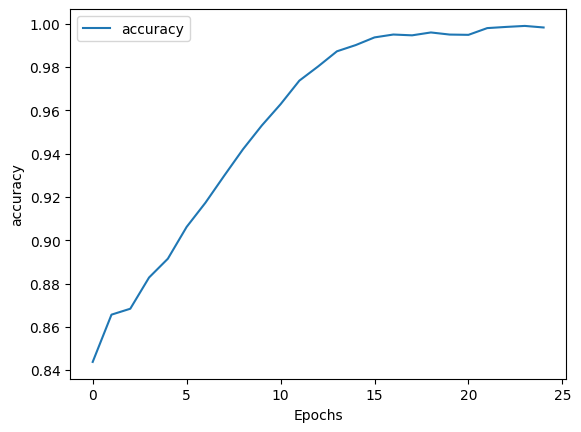

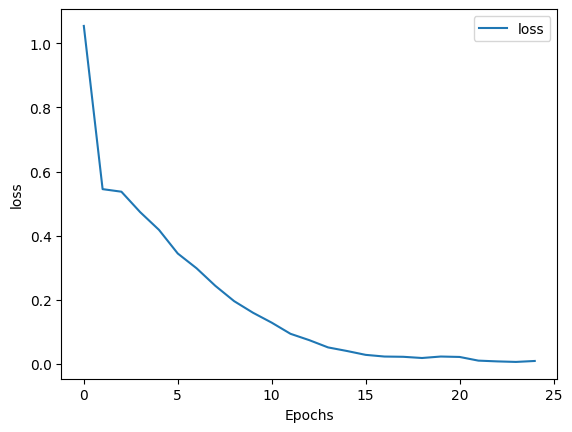

In [36]:
import matplotlib.pyplot as plt

# plot utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
#     plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, string])
    #     plt.legend([string, 'val_'+string])
    plt.show()
    
# plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

<h2>Saving the weights</h2>

In [37]:
KERAS_MODEL = "model.h5"
TOKENIZER_MODEL = "tokenizer.pkl"
    
model.save(KERAS_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)

NameError: name 'encoder' is not defined

<h1>Testing (Error Will Come With GPU, Try Instead Recreating section, without GPU)</h1>

In [38]:
with strategy.scope():
    tokenized_test_text = tokenizer.texts_to_sequences(["EMPHASIS ON USE OF HINDI IN RAILWAYS The Chairman, Railway Board, Shri R.K.Singh ha"])
    x_train = keras.preprocessing.sequence.pad_sequences(tokenized_test_text, maxlen=max_sequence_len_tmp)
    ans = model.predict([x_train])
    class_labels = ans.argmax(axis=-1)
    print(ans)

CancelledError: Graph execution error:

RecvAsync is cancelled.
	 [[{{node sequential/dense_1/Softmax/_53}}]] [Op:__inference_predict_function_34558]

In [ ]:
print(class_labels)

<h1>For recreating the model from weights, Without gpu, As error is comming in gpu (NO GPU)</h1>
CancelledError                            Traceback (most recent call last)
Cell In[40], line 4
      2 tokenized_test_text = tokenizer.texts_to_sequences(["EMPHASIS ON USE OF HINDI IN RAILWAYS The Chairman, Railway Board, Shri R.K.Singh ha"])
      3 x_train = keras.preprocessing.sequence.pad_sequences(tokenized_test_text, maxlen=max_sequence_len_tmp)
----> 4 ans = model.predict([x_train])
      5 class_labels = ans.argmax(axis=-1)
      6 print(ans)

File /opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py:70, in filter_traceback.<locals>.error_handler(*args, **kwargs)
     67     filtered_tb = _process_traceback_frames(e.__traceback__)
     68     # To get the full stack trace, call:
     69     # `tf.debugging.disable_traceback_filtering()`
---> 70     raise e.with_traceback(filtered_tb) from None
     71 finally:
     72     del filtered_tb

File /opt/conda/lib/python3.10/site-packages/tensorflow/python/eager/execute.py:52, in quick_execute(op_name, num_outputs, inputs, attrs, ctx, name)
     50 try:
     51   ctx.ensure_initialized()
---> 52   tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
     53                                       inputs, attrs, num_outputs)
     54 except core._NotOkStatusException as e:
     55   if name is not None:

CancelledError: Graph execution error:

RecvAsync is cancelled.
	 [[{{node sequential/dense_1/Softmax/_53}}]] [Op:__inference_predict_function_34609]

In [1]:
import tensorflow as tf
from tensorflow import keras

import pandas as pd
import numpy as np

In [2]:
# As per last execution during training
vocab_size = 40310
max_sequence_len_tmp = 550

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 300, input_length=max_sequence_len_tmp),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(61, activation='softmax')
])  

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 550, 300)          12093000  
                                                                 
 bidirectional (Bidirectiona  (None, 550, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 61)                7869      
                                                                 
Total params: 12,403,077
Trainable params: 12,403,077
No

In [5]:
model.load_weights('/kaggle/input/tmp-data/model.h5')

In [8]:
def load_tokenizer():
    with open('/kaggle/input/tmp-data/tokenizer.pkl', 'rb') as handle:
        tokenizer = pickle.load(handle)

    print(len(tokenizer.word_index))
    print('loading of tokenizer completed........')

    return tokenizer

tokenizer = load_tokenizer()

NameError: name 'pickle' is not defined

In [6]:
tokenized_test_text = tokenizer.texts_to_sequences(["Supreme court gives notice to car owner regarding tax dues"])
x_train = keras.preprocessing.sequence.pad_sequences(tokenized_test_text, maxlen=max_sequence_len_tmp)
ans = model.predict([x_train])
print(ans)

NameError: name 'tokenizer' is not defined

<h2>Finding Top 3 probable minstries as per the model's output</h2>

In [ ]:
# dict_items([('Not Ministry', 61), ('Ministry of Railways', 1), ('Ministry of Rural Development', 2), ('Ministry of Steel', 3), ('Ministry of Science & Technology', 4), ('Ministry of Information & Broadcasting', 5), ('Ministry of Food Processing Industries', 6), ('Ministry of Health and Family Welfare', 7), ('Ministry of Human Resource Development', 8), ('Ministry of Agriculture', 9), ('Ministry of Environment and Forests', 10), ('Ministry of Chemicals and Fertilizers', 11), ('Ministry of Water Resources', 12), ('Ministry of Defence', 13), ('Ministry of Petroleum & Natural Gas', 14), ("President's Secretariat", 15), ('Ministry of Micro,Small & Medium Enterprises', 16), ('Ministry of Mines', 17), ('Ministry of Tourism', 18), ('Ministry of Housing & Urban Affairs', 19), ('Ministry of Coal', 20), ("Prime Minister's Office", 21), ('Ministry of Textiles', 22), ('Ministry of Commerce & Industry', 23), ('Ministry of External Affairs', 24), ('Ministry of Social Justice & Empowerment', 25), ('Ministry of Power', 26), ('Ministry of Consumer Affairs, Food & Public Distribution', 27), ('Ministry of Heavy Industries & Public Enterprises', 28), ('Ministry of Communications', 29), ('Ministry of Shipping', 30), ('Ministry of Finance', 31), ('Ministry of Tribal Affairs', 32), ('Ministry of Statistics & Programme Implementation', 33), ('Ministry of Labour & Employment', 34), ('Ministry of Law & Justice', 35), ("Vice President's Secretariat", 36), ('Ministry of Civil Aviation', 37), ('Ministry for Development of North-East Region', 38), ('UPSC', 39), ('Ministry of Agro & Rural Industries', 40), ('Ministry of Home Affairs', 41), ('Ministry of Youth Affairs and Sports', 42), ('Special Service and Features', 43), ('Ministry of New and Renewable Energy', 44), ('Ministry of Parliamentary Affairs', 45), ('Planning Commission', 46), ('Ministry of Personnel, Public Grievances & Pensions', 47), ('Election Commission', 48), ('Department of Space', 49), ('Ministry of Disinvestment', 50), ('Department of Ocean Development', 51), ('Ministry of Overseas Indian Affairs', 52), ('Ministry of Housing and Urban Poverty Alleviation', 53), ('Ministry of Culture', 54), ('Ministry of Company Affairs', 55), ('Ministry of Panchayati Raj', 56), ('Cabinet Committee on Economic Affairs (CCEA)', 57), ('Cabinet', 58), ('Department of Atomic Energy', 59), ('Cabinet Committee Decisions', 60)])

In [ ]:
class_labels = ans.argmax(axis=-1)
print(class_labels)
top_3_labels = np.argsort(ans)[-3:]
print(top_3_labels)